# 14.3 1880-2010年间全美婴儿姓名

美国社会保障总署（SSA）提供了一份从1880年到现在的婴儿名字频率数据。Hadley Wickham（许多流行R包的作者）经常用这份数据来演示R的数据处理功能。

我们要做一些数据规整才能加载这个数据集，这么做就会产生一个如下的DataFrame：

你可以用这个数据集做很多事，例如：

- 计算指定名字（可以是你自己的，也可以是别人的）的年度比例。
- 计算某个名字的相对排名。
- 计算各年度最流行的名字，以及增长或减少最快的名字。
- 分析名字趋势：元音、辅音、长度、总体多样性、拼写变化、首尾字母等。
- 分析外源性趋势：圣经中的名字、名人、人口结构变化等。

利用前面介绍过的那些工具，这些分析工作都能很轻松地完成，我会讲解其中的一些。

到编写本书时为止，美国社会保障总署将该数据库按年度制成了多个数据文件，其中给出了每个性别/名字组合的出生总数。这些文件的原始档案可以在这里获取：[http://www.ssa.gov/oact/babynames/limits.html](http://www.ssa.gov/oact/babynames/limits.html)。

如果你在阅读本书的时候这个页面已经不见了，也可以用搜索引擎找找。

下载"National data"文件names.zip，解压后的目录中含有一组文件（如yob1880.txt）。我用UNIX的head命令查看了其中一个文件的前10行（在Windows上，你可以用more命令，或直接在文本编辑器中打开）：

由于这是一个非常标准的以逗号隔开的格式，所以可以用pandas.read_csv将其加载到DataFrame中：

In [1]:
import pandas as pd
import numpy as np

In [2]:
names1880 = pd.read_csv('../../datasets/babynames/yob1880.txt',
                        names=['name', 'sex', 'births']
                       )



In [3]:
names1880

,name,sex,births
0,Mary,F,7065
1,Anna,F,2604
2,Emma,F,2003
3,Elizabeth,F,1939
4,Minnie,F,1746
...,...,...,...
1995,Woodie,M,5
1996,Worthy,M,5
1997,Wright,M,5
1998,York,M,5


这些文件中仅含有当年出现超过5次的名字。为了简单起见，我们可以用births列的sex分组小计表示该年度的births总计：

In [4]:
names1880.groupby('sex').births.sum()

sex
F     90993
M    110493
Name: births, dtype: int64

由于该数据集按年度被分隔成了多个文件，所以第一件事情就是要将所有数据都组装到一个DataFrame里面，并加上一个year字段。使用pandas.concat即可达到这个目的：

In [6]:
years = range(1880, 2011)


pieces = list()
columns = ['name', 'sex', 'births']


for year in years:
    path = '../../datasets/babynames/yob%d.txt' % year
    frame = pd.read_csv(path, names=columns)

    frame['year'] = year
    pieces.append(frame)

# Concatenate everything into a single DataFrame
names = pd.concat(pieces, ignore_index=True)

这里需要注意几件事情。第一，concat默认是按行将多个DataFrame组合到一起的；第二，必须指定ignore_index=True，因为我们不希望保留read_csv所返回的原始行号。现在我们得到了一个非常大的DataFrame，它含有全部的名字数据：

In [7]:
names

,name,sex,births,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880
...,...,...,...,...
1690779,Zymaire,M,5,2010
1690780,Zyonne,M,5,2010
1690781,Zyquarius,M,5,2010
1690782,Zyran,M,5,2010


有了这些数据之后，我们就可以利用groupby或pivot_table在year和sex级别上对其进行聚合了，如图14-4所示：

In [8]:
total_births = names.pivot_table('births', 
                                 index='year',
                                 columns='sex', aggfunc=sum
                                )


total_births.tail()

sex,F,M
year,,
2006,1896468,2050234
2007,1916888,2069242
2008,1883645,2032310
2009,1827643,1973359
2010,1759010,1898382


<Axes: title={'center': 'Total births by sex and year'}, xlabel='year'>

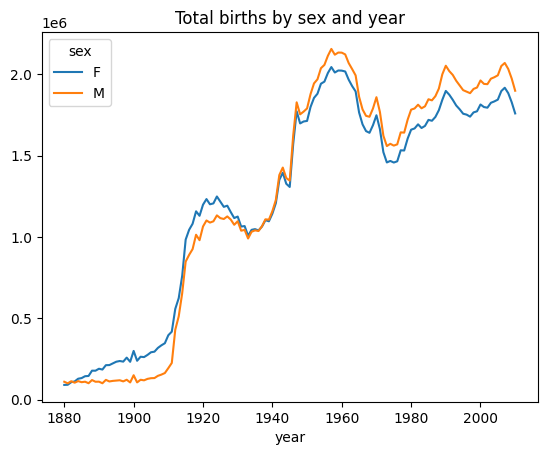

In [9]:
total_births.plot(title='Total births by sex and year')

下面我们来插入一个prop列，用于存放指定名字的婴儿数相对于总出生数的比例。prop值为0.02表示每100名婴儿中有2名取了当前这个名字。因此，我们先按year和sex分组，然后再将新列加到各个分组上：

In [10]:
def add_prop(group):
    group['prop'] = group.births / group.births.sum()
    return group


names = names.groupby(['year', 'sex']).apply(add_prop)

/tmp/ipykernel_140912/4062025606.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  names = names.groupby(['year', 'sex']).apply(add_prop)


现在，完整的数据集就有了下面这些列：

In [11]:
names

,name,sex,births,year,prop
0,Mary,F,7065,1880,0.077643
1,Anna,F,2604,1880,0.028618
2,Emma,F,2003,1880,0.022013
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188
...,...,...,...,...,...
1690779,Zymaire,M,5,2010,0.000003
1690780,Zyonne,M,5,2010,0.000003
1690781,Zyquarius,M,5,2010,0.000003
1690782,Zyran,M,5,2010,0.000003


在执行这样的分组处理时，一般都应该做一些有效性检查，比如验证所有分组的prop的总和是否为1：

In [12]:
names.groupby(['year', 'sex']).prop.sum()

year  sex
1880  F      1.0
      M      1.0
1881  F      1.0
      M      1.0
1882  F      1.0
            ... 
2008  M      1.0
2009  F      1.0
      M      1.0
2010  F      1.0
      M      1.0
Name: prop, Length: 262, dtype: float64

工作完成。为了便于实现更进一步的分析，我需要取出该数据的一个子集：每对sex/year组合的前1000个名字。这又是一个分组操作：

In [13]:
def get_top1000(group):
    return group.sort_values(by='births', ascending=False)[:1000]


grouped = names.groupby(['year', 'sex'])
top1000 = grouped.apply(get_top1000)


# Drop the group index, not needed
top1000.reset_index(inplace=True, drop=True)

如果你喜欢DIY的话，也可以这样：

In [14]:
pieces = []


for year, group in names.groupby(['year', 'sex']):
    pieces.append(group.sort_values(by='births', ascending=False)[:1000])
    
    
top1000 = pd.concat(pieces, ignore_index=True)

现在的结果数据集就小多了：

In [15]:
top1000

,name,sex,births,year,prop
0,Mary,F,7065,1880,0.077643
1,Anna,F,2604,1880,0.028618
2,Emma,F,2003,1880,0.022013
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188
...,...,...,...,...,...
261872,Camilo,M,194,2010,0.000102
261873,Destin,M,194,2010,0.000102
261874,Jaquan,M,194,2010,0.000102
261875,Jaydan,M,194,2010,0.000102


接下来的数据分析工作就针对这个top1000数据集了。

## 分析命名趋势

有了完整的数据集和刚才生成的top1000数据集，我们就可以开始分析各种命名趋势了。首先将前1000个名字分为男女两个部分：

In [16]:
boys = top1000[top1000.sex == 'M']

girls = top1000[top1000.sex == 'F']

这是两个简单的时间序列，只需稍作整理即可绘制出相应的图表（比如每年叫做John和Mary的婴儿数）。我们先生成一张按year和name统计的总出生数透视表：

In [18]:
total_births = top1000.pivot_table('births', 
                                   index='year',
                                   columns='name',
                                   aggfunc=sum
                                  )

total_births

name,Aaden,Aaliyah,Aarav,Aaron,Aarush,Ab,Abagail,Abb,Abbey,Abbie,...,Zoa,Zoe,Zoey,Zoie,Zola,Zollie,Zona,Zora,Zula,Zuri
year,,,,,,,,,,,,,,,,,,,,,
1880,NaN,NaN,NaN,102.0,NaN,NaN,NaN,NaN,NaN,71.0,...,8.0,23.0,NaN,NaN,7.0,NaN,8.0,28.0,27.0,NaN
1881,NaN,NaN,NaN,94.0,NaN,NaN,NaN,NaN,NaN,81.0,...,NaN,22.0,NaN,NaN,10.0,NaN,9.0,21.0,27.0,NaN
1882,NaN,NaN,NaN,85.0,NaN,NaN,NaN,NaN,NaN,80.0,...,8.0,25.0,NaN,NaN,9.0,NaN,17.0,32.0,21.0,NaN
1883,NaN,NaN,NaN,105.0,NaN,NaN,NaN,NaN,NaN,79.0,...,NaN,23.0,NaN,NaN,10.0,NaN,11.0,35.0,25.0,NaN
1884,NaN,NaN,NaN,97.0,NaN,NaN,NaN,NaN,NaN,98.0,...,13.0,31.0,NaN,NaN,14.0,6.0,8.0,58.0,27.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006,NaN,3737.0,NaN,8279.0,NaN,NaN,297.0,NaN,404.0,440.0,...,NaN,5145.0,2839.0,530.0,NaN,NaN,NaN,NaN,NaN,NaN
2007,NaN,3941.0,NaN,8914.0,NaN,NaN,313.0,NaN,349.0,468.0,...,NaN,4925.0,3028.0,526.0,NaN,NaN,NaN,NaN,NaN,NaN
2008,955.0,4028.0,219.0,8511.0,NaN,NaN,317.0,NaN,344.0,400.0,...,NaN,4764.0,3438.0,492.0,NaN,NaN,NaN,NaN,NaN,NaN


现在，我们用DataFrame的plot方法绘制几个名字的曲线图（见图14-5）：

In [19]:
total_births.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131 entries, 1880 to 2010
Columns: 6868 entries, Aaden to Zuri
dtypes: float64(6868)
memory usage: 6.9 MB


array([<Axes: xlabel='year'>, <Axes: xlabel='year'>,
       <Axes: xlabel='year'>, <Axes: xlabel='year'>,
       <Axes: xlabel='year'>, <Axes: xlabel='year'>], dtype=object)

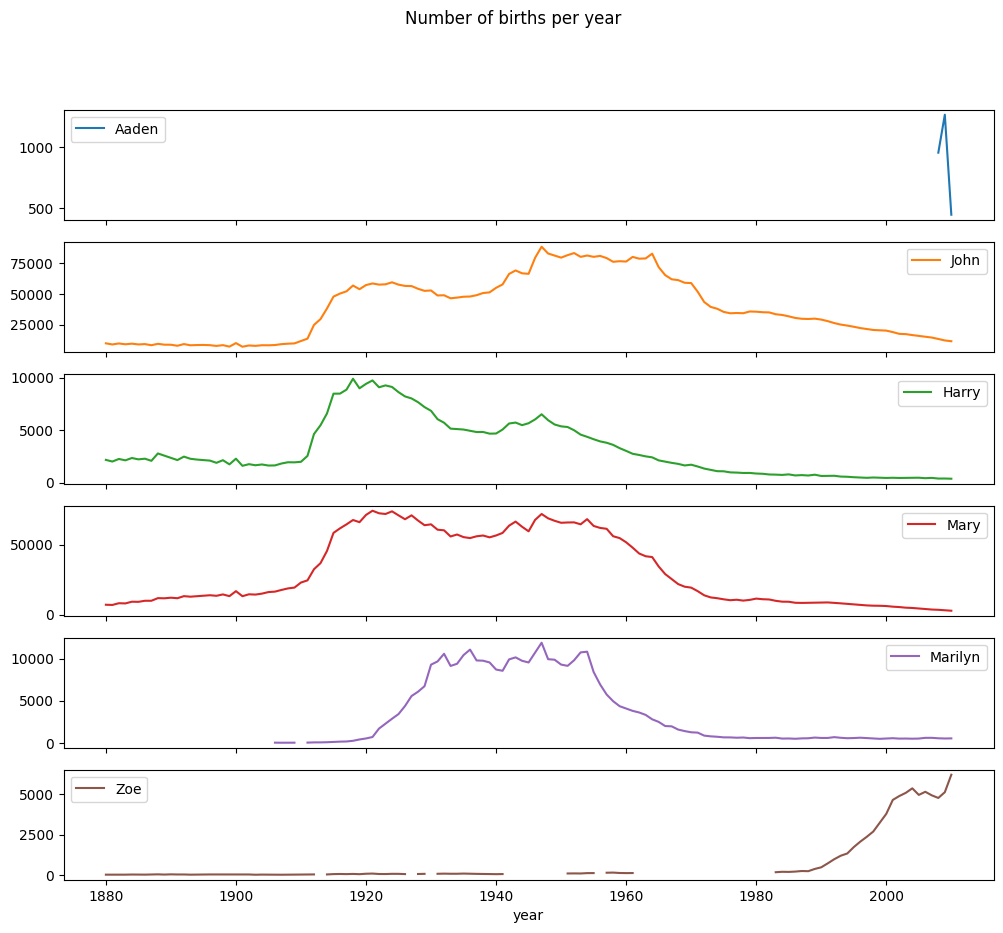

In [23]:
subset = total_births[['Aaden', 'John', 'Harry', 'Mary', 'Marilyn', 'Zoe']]


subset.plot(subplots=True, 
            figsize=(12, 10),
            grid=False,
            title="Number of births per year"
           )

从图中可以看出，这几个名字在美国人民的心目中已经风光不再了。但事实并非如此简单，我们在下一节中就能知道是怎么一回事了。

## 评估命名多样性的增长

一种解释是父母愿意给小孩起常见的名字越来越少。这个假设可以从数据中得到验证。一个办法是计算最流行的1000个名字所占的比例，我按year和sex进行聚合并绘图（见图14-6）：

<Axes: title={'center': 'Sum of table1000.prop by year and sex'}, xlabel='year'>

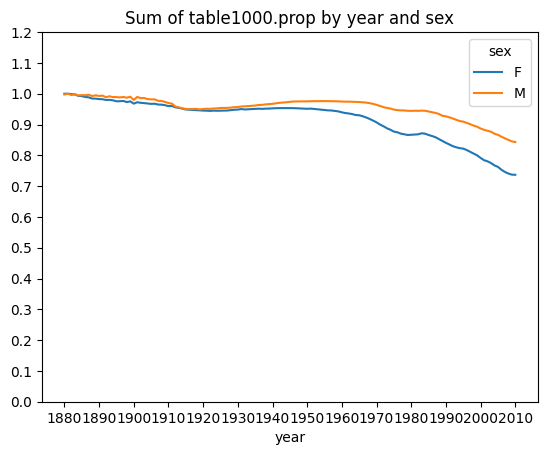

In [24]:
table = top1000.pivot_table('prop', 
                            index='year',
                            columns='sex', 
                            aggfunc=sum
                           )

table.plot(title='Sum of table1000.prop by year and sex',
           yticks=np.linspace(0, 1.2, 13), 
           xticks=range(1880, 2020, 10)
          )


从图中可以看出，名字的多样性确实出现了增长（前1000项的比例降低）。另一个办法是计算占总出生人数前50%的不同名字的数量，这个数字不太好计算。我们只考虑2010年男孩的名字：

In [25]:
df = boys[boys.year == 2010]

df

,name,sex,births,year,prop
260877,Jacob,M,21875,2010,0.011523
260878,Ethan,M,17866,2010,0.009411
260879,Michael,M,17133,2010,0.009025
260880,Jayden,M,17030,2010,0.008971
260881,William,M,16870,2010,0.008887
...,...,...,...,...,...
261872,Camilo,M,194,2010,0.000102
261873,Destin,M,194,2010,0.000102
261874,Jaquan,M,194,2010,0.000102
261875,Jaydan,M,194,2010,0.000102


在对prop降序排列之后，我们想知道前面多少个名字的人数加起来才够50%。虽然编写一个for循环确实也能达到目的，但NumPy有一种更聪明的矢量方式。先计算prop的累计和cumsum，然后再通过searchsorted方法找出0.5应该被插入在哪个位置才能保证不破坏顺序：

In [26]:
prop_cumsum = df.sort_values(by='prop', ascending=False).prop.cumsum()


prop_cumsum[:10]

260877    0.011523
260878    0.020934
260879    0.029959
260880    0.038930
260881    0.047817
260882    0.056579
260883    0.065155
260884    0.073414
260885    0.081528
260886    0.089621
Name: prop, dtype: float64

In [27]:
prop_cumsum.values.searchsorted(0.5)

116

由于数组索引是从0开始的，因此我们要给这个结果加1，即最终结果为117。拿1900年的数据来做个比较，这个数字要小得多：

In [28]:
df = boys[boys.year == 1900]


in1900 = df.sort_values(by='prop', ascending=False).prop.cumsum()


in1900.values.searchsorted(0.5) + 1

25

现在就可以对所有year/sex组合执行这个计算了。按这两个字段进行groupby处理，然后用一个函数计算各分组的这个值：

In [29]:
def get_quantile_count(group, q=0.5):
    group = group.sort_values(by='prop', ascending=False)
    return group.prop.cumsum().values.searchsorted(q) + 1


diversity = top1000.groupby(['year', 'sex']).apply(get_quantile_count)
diversity = diversity.unstack('sex')

现在，diversity这个DataFrame拥有两个时间序列（每个性别各一个，按年度索引）。通过IPython，你可以查看其内容，还可以像之前那样绘制图表（如图14-7所示）：

In [30]:
diversity.head()

sex,F,M
year,,
1880,38,14
1881,38,14
1882,38,15
1883,39,15
1884,39,16


<Axes: title={'center': 'Number of popular names in top 50%'}, xlabel='year'>

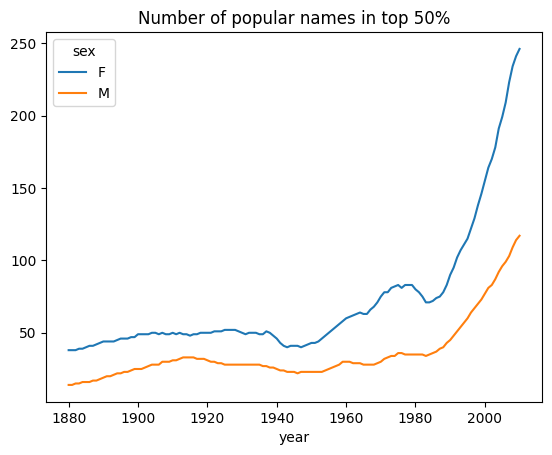

In [31]:
diversity.plot(title="Number of popular names in top 50%")

从图中可以看出，女孩名字的多样性总是比男孩的高，而且还在变得越来越高。读者们可以自己分析一下具体是什么在驱动这个多样性（比如拼写形式的变化）。

##  “最后一个字母”的变革

2007年，一名婴儿姓名研究人员Laura Wattenberg在她自己的网站上指出（http://www.babynamewizard.com）：近百年来，男孩名字在最后一个字母上的分布发生了显著的变化。为了了解具体的情况，我首先将全部出生数据在年度、性别以及末字母上进行了聚合：

In [32]:
# extract last letter from name column
get_last_letter = lambda x: x[-1]
last_letters = names.name.map(get_last_letter)
last_letters.name = 'last_letter'


table = names.pivot_table('births', 
                          index=last_letters,
                          columns=['sex', 'year'], 
                          aggfunc=sum
                         )

然后，我选出具有一定代表性的三年，并输出前面几行：

In [33]:
subtable = table.reindex(columns=[1910, 1960, 2010], level='year')


subtable.head()

sex                 F                            M                    
year             1910      1960      2010     1910      1960      2010
last_letter                                                           
a            108376.0  691247.0  670605.0    977.0    5204.0   28438.0
b                 NaN     694.0     450.0    411.0    3912.0   38859.0
c                 5.0      49.0     946.0    482.0   15476.0   23125.0
d              6750.0    3729.0    2607.0  22111.0  262112.0   44398.0
e            133569.0  435013.0  313833.0  28655.0  178823.0  129012.0

接下来我们需要按总出生数对该表进行规范化处理，以便计算出各性别各末字母占总出生人数的比例：

In [34]:
subtable.sum()

sex  year
F    1910     396416.0
     1960    2022062.0
     2010    1759010.0
M    1910     194198.0
     1960    2132588.0
     2010    1898382.0
dtype: float64

In [36]:
letter_prop = subtable / subtable.sum()

letter_prop

sex                 F                             M                    
year             1910      1960      2010      1910      1960      2010
last_letter                                                            
a            0.273390  0.341853  0.381240  0.005031  0.002440  0.014980
b                 NaN  0.000343  0.000256  0.002116  0.001834  0.020470
c            0.000013  0.000024  0.000538  0.002482  0.007257  0.012181
d            0.017028  0.001844  0.001482  0.113858  0.122908  0.023387
e            0.336941  0.215133  0.178415  0.147556  0.083853  0.067959
f                 NaN  0.000010  0.000055  0.000783  0.004325  0.001188
g            0.000144  0.000157  0.000374  0.002250  0.009488  0.001404
h            0.051529  0.036224  0.075852  0.045562  0.037907  0.051670
i            0.001526  0.039965  0.031734  0.000844  0.000603  0.022628
j                 NaN       NaN  0.000090       NaN       NaN  0.000769
k            0.000121  0.000156  0.000356  0.036581  0.049384  0.018541
l            0.043189  0.033867  0.026356  0.065016  0.104904  0.070367
m            0.001201  0.008613  0.002588  0.058044  0.033827  0.024657
n            0.079240  0.130687  0.140210  0.143415  0.152522  0.362771
o            0.001660  0.002439  0.001243  0.017065  0.012829  0.042681
p            0.000018  0.000023  0.000020  0.003172  0.005675  0.001269
q                 NaN       NaN  0.000030       NaN       NaN  0.000180
r            0.013390  0.006764  0.018025  0.064481  0.031034  0.087477
s            0.039042  0.012764  0.013332  0.130815  0.102730  0.065145
t            0.027438  0.015201  0.007830  0.072879  0.065655  0.022861
u            0.000684  0.000574  0.000417  0.000124  0.000057  0.001221
v                 NaN  0.000060  0.000117  0.000113  0.000037  0.001434
w            0.000020  0.000031  0.001182  0.006329  0.007711  0.016148
x            0.000015  0.000037  0.000727  0.003965  0.001851  0.008614
y            0.110972  0.152569  0.116828  0.077349  0.160987  0.058168
z            0.002439  0.000659  0.000704  0.000170  0.000184  0.001831

有了这个字母比例数据之后，就可以生成一张各年度各性别的条形图了，如图14-8所示：

<Axes: title={'center': 'Female'}, xlabel='last_letter'>

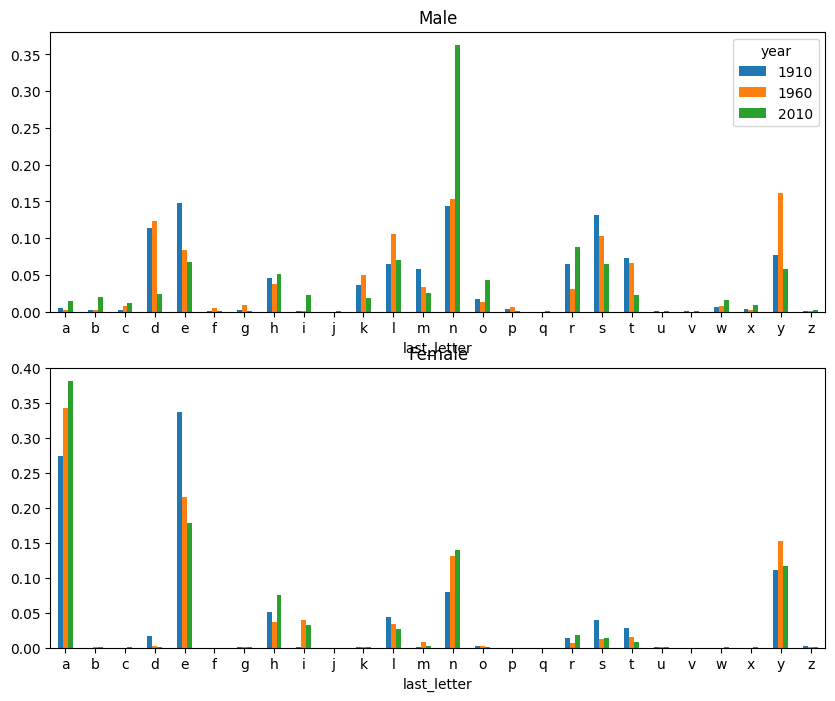

In [37]:
import matplotlib.pyplot as plt



fig, axes = plt.subplots(2, 1, figsize=(10, 8))


letter_prop['M'].plot(kind='bar', rot=0, ax=axes[0], title='Male')
letter_prop['F'].plot(kind='bar', rot=0, ax=axes[1], title='Female',legend=False)

可以看出，从20世纪60年代开始，以字母"n"结尾的男孩名字出现了显著的增长。回到之前创建的那个完整表，按年度和性别对其进行规范化处理，并在男孩名字中选取几个字母，最后进行转置以便将各个列做成一个时间序列：

In [38]:
letter_prop = table / table.sum()

dny_ts = letter_prop.loc[['d', 'n', 'y'], 'M'].T

dny_ts.head()

last_letter,d,n,y
year,,,
1880,0.083055,0.153213,0.075760
1881,0.083247,0.153214,0.077451
1882,0.085340,0.149560,0.077537
1883,0.084066,0.151646,0.079144
1884,0.086120,0.149915,0.080405


有了这个时间序列的DataFrame之后，就可以通过其plot方法绘制出一张趋势图了（如图14-9所示）：

<Axes: xlabel='year'>

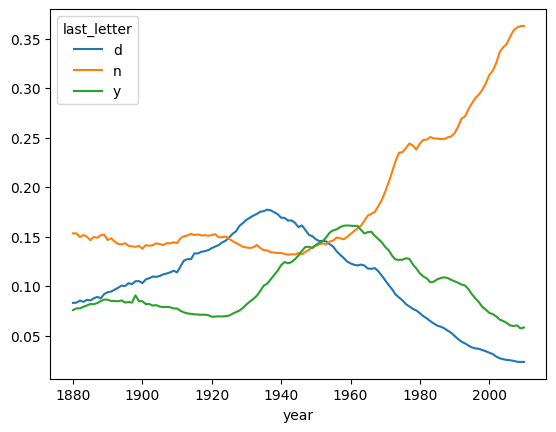

In [39]:
dny_ts.plot()

## 变成女孩名字的男孩名字（以及相反的情况）

另一个有趣的趋势是，早年流行于男孩的名字近年来“变性了”，例如Lesley或Leslie。回到top1000数据集，找出其中以"lesl"开头的一组名字：

In [40]:
all_names = pd.Series(top1000.name.unique())


lesley_like = all_names[all_names.str.lower().str.contains('lesl')]


lesley_like

632     Leslie
2294    Lesley
4262    Leslee
4728     Lesli
6103     Lesly
dtype: object

然后利用这个结果过滤其他的名字，并按名字分组计算出生数以查看相对频率：

In [41]:
filtered = top1000[top1000.name.isin(lesley_like)]


filtered.groupby('name').births.sum()

name
Leslee      1082
Lesley     35022
Lesli        929
Leslie    370429
Lesly      10067
Name: births, dtype: int64

接下来，我们按性别和年度进行聚合，并按年度进行规范化处理：

In [42]:
table = filtered.pivot_table('births',
                             index='year',
                             columns='sex', 
                             aggfunc='sum'
                            )


table = table.div(table.sum(1), axis=0)


table.tail()

sex,F,M
year,,
2006,1.0,NaN
2007,1.0,NaN
2008,1.0,NaN
2009,1.0,NaN
2010,1.0,NaN


最后，就可以轻松绘制一张分性别的年度曲线图了（如图2-10所示）：

<Axes: xlabel='year'>

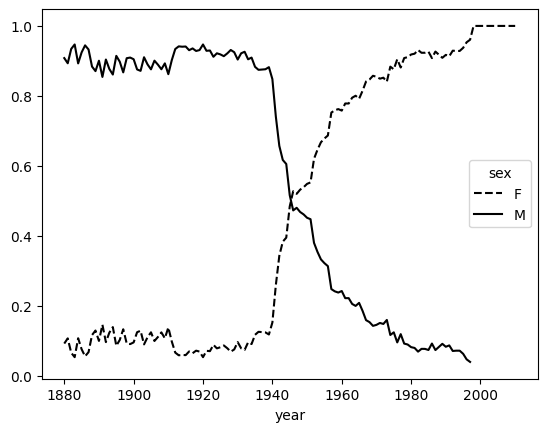

In [44]:
table.plot(style={'M': 'k-', 'F': 'k--'})